In [1]:
import mdtraj as md
import glob
import seaborn as sbn
import nglview as nv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

Read in the VR trajectories

In [2]:
vr_trajs = [] 
native_top = md.load_pdb("../cypa.pdb")
filenames = glob.glob("*_100s_*.dcd")
for dcd in filenames:
    traj = md.load_dcd(dcd, top = "../cypa_traj.pdb")
    vr_trajs.append(traj)

Let's look at the RMSD of each trajectory to see roughly what happened

<IPython.core.display.Javascript object>


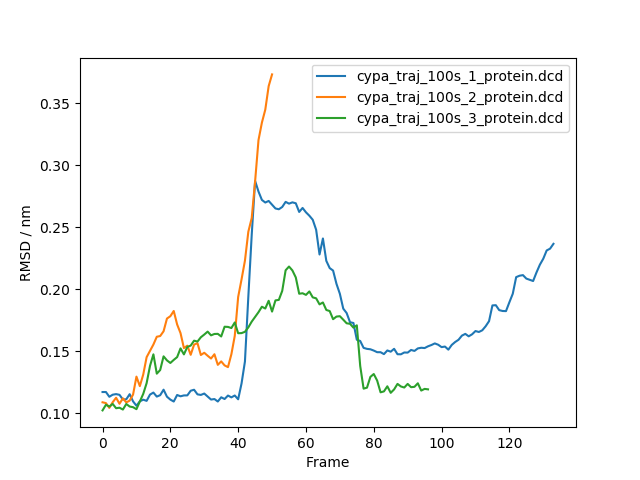

In [3]:
rmsds = [] 
for traj in vr_trajs: 
    rmsds.append(md.rmsd(traj, native_top))
    
fig = plt.figure()
for rmsd, file in zip(rmsds, filenames):
    plt.plot(rmsd, label=file)
plt.legend()
plt.xlabel("Frame")
plt.ylabel("RMSD / nm")
plt.show()

These trajectories are of users trying to move the loop defined by residues 100-110 towards residues 67-75. The orange and green trajectories indicate the user moving the loop back and forth, while something strange happened in the blue trajectory. Residues 100-110 start near residues 80-90, so we can look at the distances between these key residues 

<IPython.core.display.Javascript object>


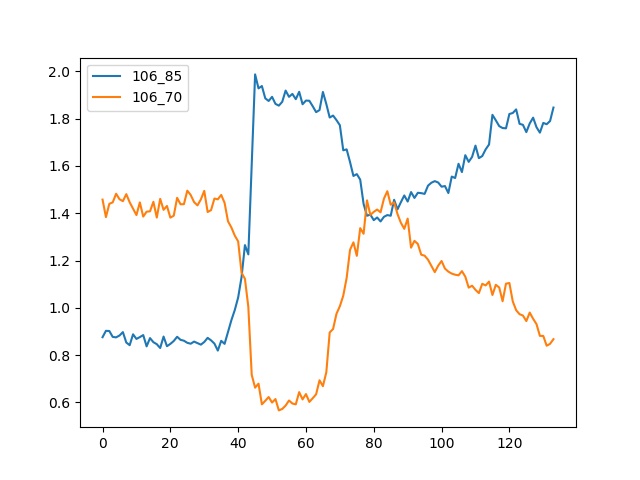

<IPython.core.display.Javascript object>


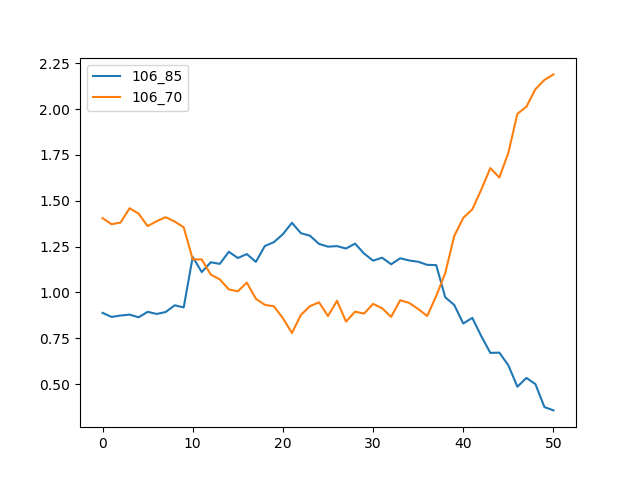

<IPython.core.display.Javascript object>


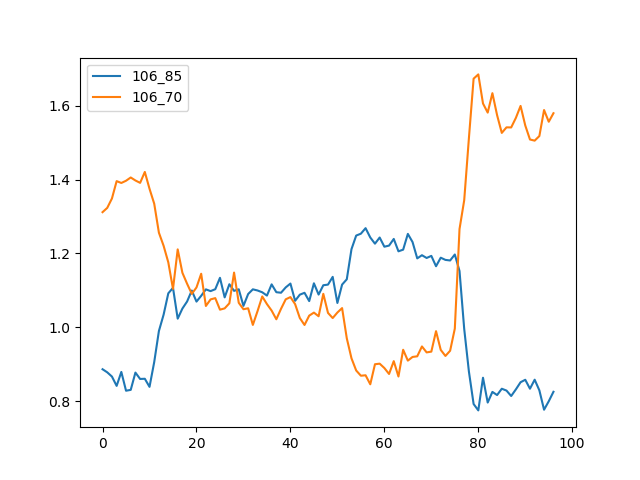

In [4]:
import itertools
#100s
contacts_res = [[106, 85],[106,70]]
#70s 
#contacts_res = list(itertools.product([72], [59]))
#print(contact_res)
for traj in vr_trajs:
    distances, pairs = md.compute_contacts(traj, contacts=contacts_res)
    distances = np.array(distances)
    
    fig = plt.figure()
    for i in range(len(pairs)):
        plt.plot(distances[:,i], label=str.format("{0}_{1}",pairs[i][0], pairs[i][1]))
    plt.legend()
    

In [5]:
nv.show_mdtraj(vr_trajs[1])

To quantify how close to the native state each trajectory gets, we can compute the fraction of native contacts over the course of the trajectory:

In [6]:
from itertools import combinations

def best_hummer_q(traj, native):
    """Compute the fraction of native contacts according the definition from
    Best, Hummer and Eaton [1]
    
    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to do the computation for
    native : md.Trajectory
        The 'native state'. This can be an entire trajecory, or just a single frame.
        Only the first conformation is used
        
    Returns
    -------
    q : np.array, shape=(len(traj),)
        The fraction of native contacts in each frame of `traj`
        
    References
    ----------
    ..[1] Best, Hummer, and Eaton, "Native contacts determine protein folding
          mechanisms in atomistic simulations" PNAS (2013)
    """
    
    BETA_CONST = 50  # 1/nm
    LAMBDA_CONST = 1.8
    NATIVE_CUTOFF = 0.45  # nanometers
    
    # get the indices of all of the heavy atoms
    heavy = native.topology.select_atom_indices('heavy')
    # get the pairs of heavy atoms which are farther than 3
    # residues apart
    heavy_pairs = np.array(
        [(i,j) for (i,j) in combinations(heavy, 2)
            if abs(native.topology.atom(i).residue.index - \
                   native.topology.atom(j).residue.index) > 3])
    
    # compute the distances between these pairs in the native state
    heavy_pairs_distances = md.compute_distances(native[0], heavy_pairs)[0]
    # and get the pairs s.t. the distance is less than NATIVE_CUTOFF
    native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]
    print("Number of native contacts", len(native_contacts))
    
    # now compute these distances for the whole trajectory
    r = md.compute_distances(traj, native_contacts)
    # and recompute them for just the native state
    r0 = md.compute_distances(native[0], native_contacts)
    
    q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
    return q  

<IPython.core.display.Javascript object>


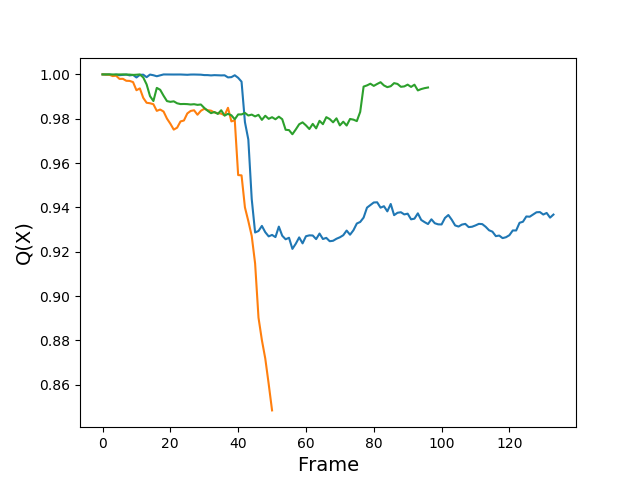

Number of native contacts 2335


C:\Users\Mike.DESKTOP-CA70LTI\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in exp


Number of native contacts 2429
Number of native contacts 2291


In [7]:
fig = plt.figure()
traj_q = []
for traj in vr_trajs: 
    q = best_hummer_q(traj, traj[0])
    traj_q.append(q)
    plt.plot(q)
    plt.xlabel('Frame', fontsize=14)
    plt.ylabel('Q(X)', fontsize=14)

plt.show()

From these we can see that one trajectory does indeed return to something close to the native state. The blue trajectory goes off to some crazy state, so we'll use this metric as a way to remove useless frames. This is of course context dependent - the energy of the state could be used to guide.

In [8]:
native_cutoff = 0.924
filtered_traj = []
for traj, q in zip(vr_trajs, traj_q): 
    orig_frames = traj.n_frames
    new_traj = traj[q > native_cutoff]
    print('Removed ', orig_frames - new_traj.n_frames, ' frames')
    filtered_traj.append(new_traj)
vr_trajs = filtered_traj

Removed  3  frames
Removed  6  frames
Removed  0  frames


## Frame Selection

We'll use clustering to select frames based on the features gathered from PCA, see cypa_simbox_analysis

In [9]:
traj = md.join(vr_trajs)
print(traj.n_frames)
output_frames = 15

273


In [10]:
contacts_res = [[ 69, 102],  [ 82, 102], [ 82,  73]]
pairwise_distances, pairs = md.compute_contacts(traj, contacts_res, scheme='closest')
print(pairwise_distances.shape)

(273, 3)


We'll just use K-means as a proof of principle, one could imagine there might be better clustering algorithms to use! 

<IPython.core.display.Javascript object>


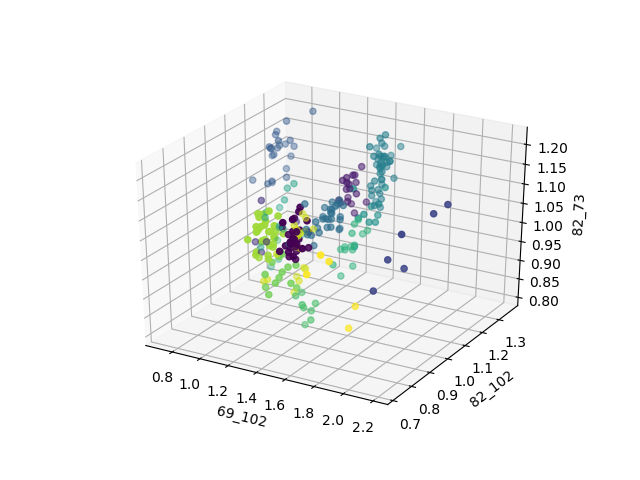

In [11]:
from sklearn.cluster import *
kmeans = KMeans(n_clusters=output_frames, n_init=100).fit(pairwise_distances)
clusters = kmeans.predict(pairwise_distances)
# compute the mean of each cluster.
cluster_centers = kmeans.cluster_centers_

if len(pairs) == 3:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pairwise_distances[:,0],pairwise_distances[:,1], pairwise_distances[:,2], c=clusters.astype(np.float), marker='o')
    ax.set_xlabel(str.format("{0}_{1}",pairs[0][0], pairs[0][1]))
    ax.set_ylabel(str.format("{0}_{1}",pairs[1][0], pairs[1][1]))
    ax.set_zlabel(str.format("{0}_{1}",pairs[2][0], pairs[2][1]))


plt.show()

Sample a single instance from each cluster, this way we sample evenly across explored space rather than getting lots of commonly visited states

In [21]:
samples = []
for i in range(kmeans.n_clusters):
    # indices of all the points that belong to cluster
    C_i = np.where(kmeans.labels_ == i)[0].tolist() 
    n_i = len(C_i) # number of points in cluster i

    # indices of the points from X to be sampled from cluster i
    sample_i = np.random.choice(C_i) 
    print(i, sample_i)
    samples.append(sample_i)

0 271
1 170
2 16
3 43
4 253
5 89
6 126
7 177
8 159
9 193
10 116
11 37
12 11
13 243
14 68


In [27]:
import os
directory = 'initial_conditions'
if not os.path.exists(directory):
    os.makedirs(directory)
for frame in samples:
    traj[frame].save_pdb(str.format("{0}/cypa_{1}.pdb",directory,frame))